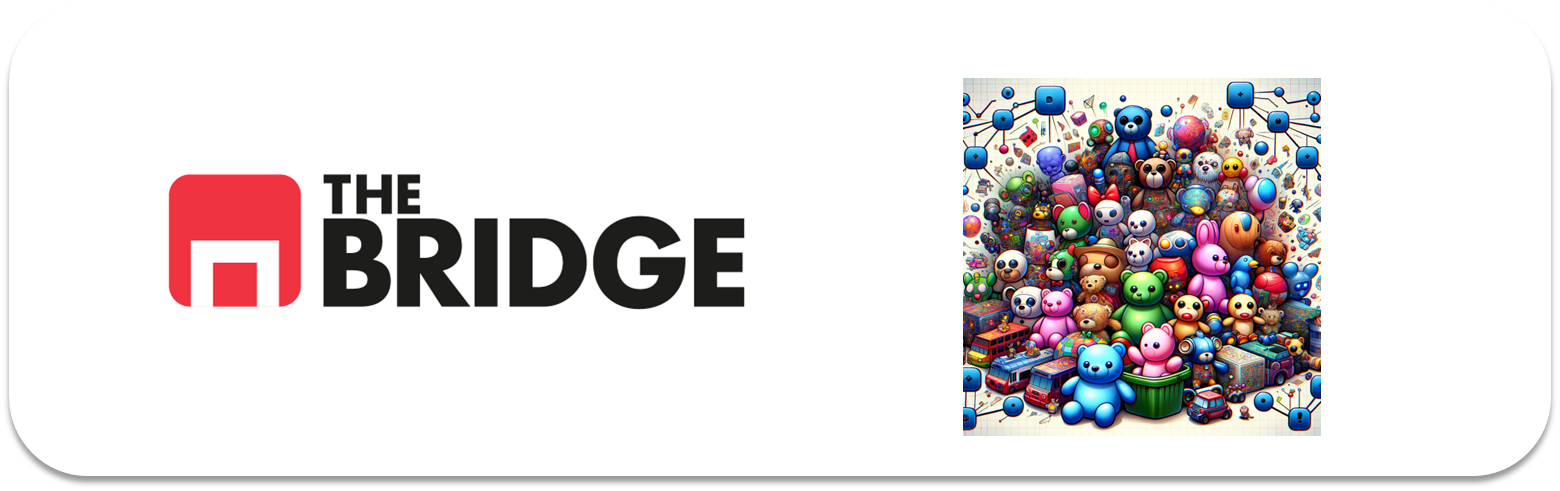

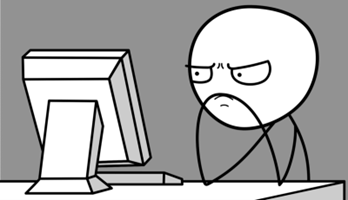

Para ejercitarte y afianzar lo aprendido sobre **Clustering Jerárquico**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Descripción del "Problema"

Existen disponibles datos de encuestas y cuestionarios a 26 instituciones. Estas instituciones han sido evaluadas bajo distintos criterios de desempeño, como profesorado, costos, ubicación, becas e infraestructura. Cada criterio va del 1 al 5, siendo 5 el mayor.

El objetivo principal será segmentar las instituciones en grupos basásndonos en los criterios antes mencionados, y luego generar descripciones y recomendaciones a seguir con respecto a cada uno de los grupos identificados. Las recomendaciones pueden ser para distintos clientes.
    </div>

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [12]:
import bootcampviztools as bt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc

from sklearn.cluster import AgglomerativeClustering

import vizdatatools as viz

#ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=)

### Ejercicio 1

Carga los datos ("Engg_College_Data") y haz una primera inspección "rápida".

In [2]:
df_eng_college = pd.read_csv('data/Engg_College_Data.csv')
df_eng_college.head()

,SR_NO,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure
0,1,A,5,2,5,5,3
1,2,B,4,2,5,5,3
2,3,C,4,5,5,4,5
3,4,D,5,4,5,4,4
4,5,E,2,5,2,2,5


In [4]:
df_eng_college.describe(include='all')

,SR_NO,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure
count,26.000000,26,26.000000,26.000000,26.000000,26.000000,26.000000
unique,NaN,26,NaN,NaN,NaN,NaN,NaN
top,NaN,A,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN
mean,13.500000,NaN,2.807692,3.576923,2.884615,2.769231,3.384615
std,7.648529,NaN,1.132051,1.331858,1.531716,1.242826,1.298520
min,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
25%,7.250000,NaN,2.000000,2.250000,1.250000,2.000000,3.000000
50%,13.500000,NaN,3.000000,4.000000,3.000000,2.000000,3.000000
75%,19.750000,NaN,3.000000,5.000000,4.000000,4.000000,4.750000


In [5]:
df_eng_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SR_NO           26 non-null     int64 
 1   Engg_College    26 non-null     object
 2   Teaching        26 non-null     int64 
 3   Fees            26 non-null     int64 
 4   Placements      26 non-null     int64 
 5   Internship      26 non-null     int64 
 6   Infrastructure  26 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 1.6+ KB


*Tanto "SR_NO" como "Engg_College" son valores únicos, nos quedamos con "Engg_College"*

### Ejercicio 2

Crea un train_set con una única variable de tipo índice (que nos servirá para identifcar a las instituciones en cada clúster)

*Las dos columnas con valores unicos para todas las intancias son SR_NO y Engg_College, nos quedamos con esta última*

In [3]:
train_set = df_eng_college.drop(["SR_NO"], axis = 1)

### Ejercicio 3

Determina el tipo de cada variable, haciendo un univariante de las mismas.

In [5]:
features = train_set.columns.to_list()
features.remove("Engg_College")
features

['Teaching', 'Fees', 'Placements', 'Internship', 'Infrastructure']

*Considerando todas como numéricas continuas*

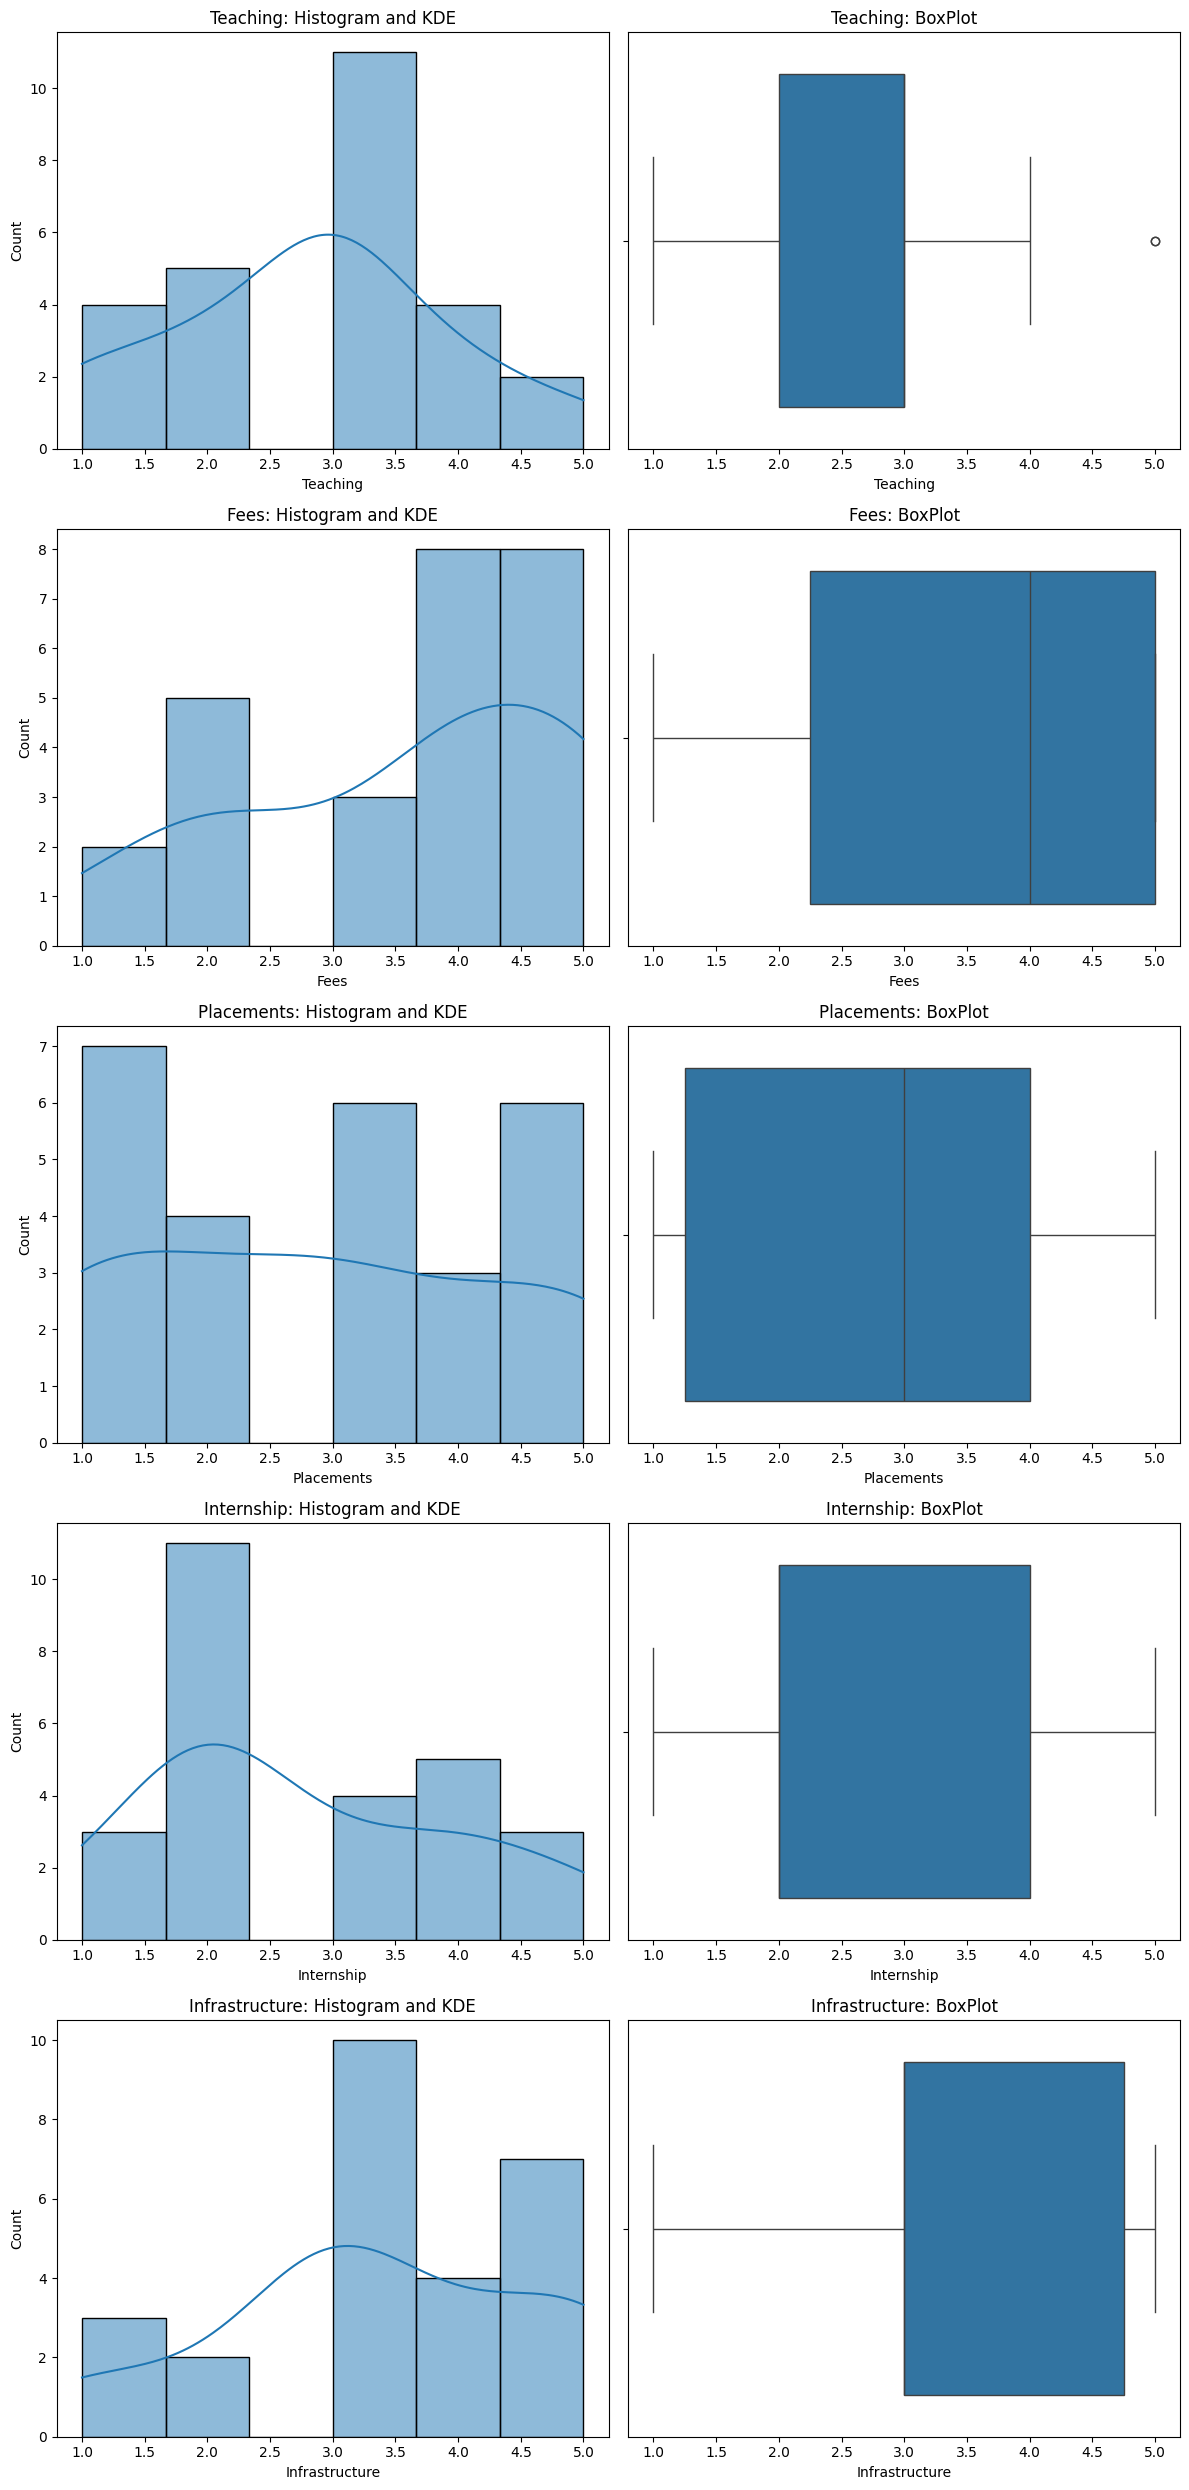

In [6]:
viz.plot_multiple_histograms_KDEs_boxplots(train_set, features)

*Nos podíamos haber ahorrado el gráfico anterior acudiendo a la definición que nos dieron al principio y haciendo un value_counts*

In [8]:
for col in features:
    print(train_set[col].value_counts())
    print("****")

Teaching
3    11
2     5
4     4
1     4
5     2
Name: count, dtype: int64
****
Fees
5    8
4    8
2    5
3    3
1    2
Name: count, dtype: int64
****
Placements
1    7
5    6
3    6
2    4
4    3
Name: count, dtype: int64
****
Internship
2    11
4     5
3     4
5     3
1     3
Name: count, dtype: int64
****
Infrastructure
3    10
5     7
4     4
1     3
2     2
Name: count, dtype: int64
****


*Como ya sabíamos son variables numéricas discretas considerables como variables categóricas ordinales*

*Gráficamente:*

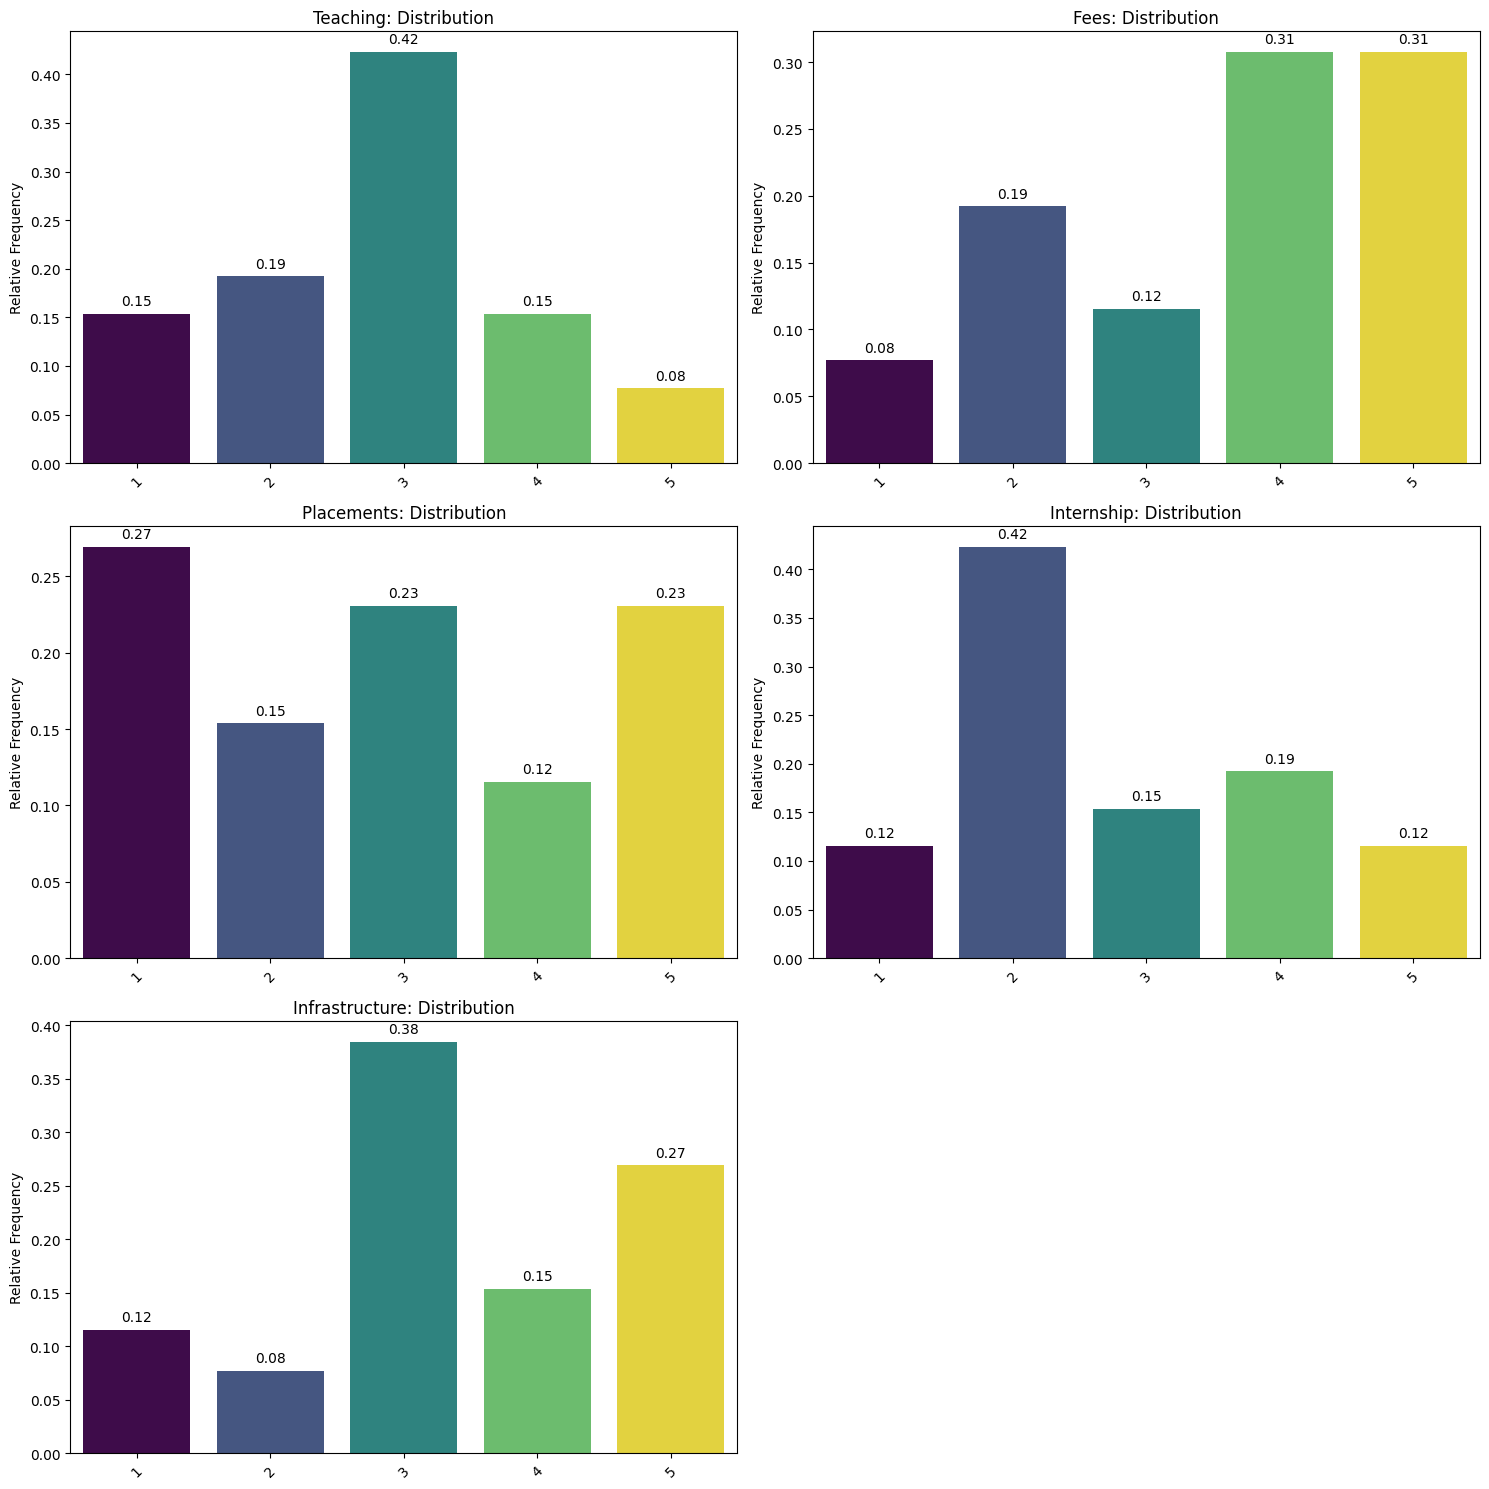

In [9]:
viz.plot_multiple_categorical_distributions(train_set, features, relative=True)

### Ejercicio 4

Es hora de hacer el miniEDA. Fíjate que en este caso no tenemos continuas numéricas que nos permitan ver claramente una clusterización con scatter plots. Compruébalo haciendo un pairplot del dataset.

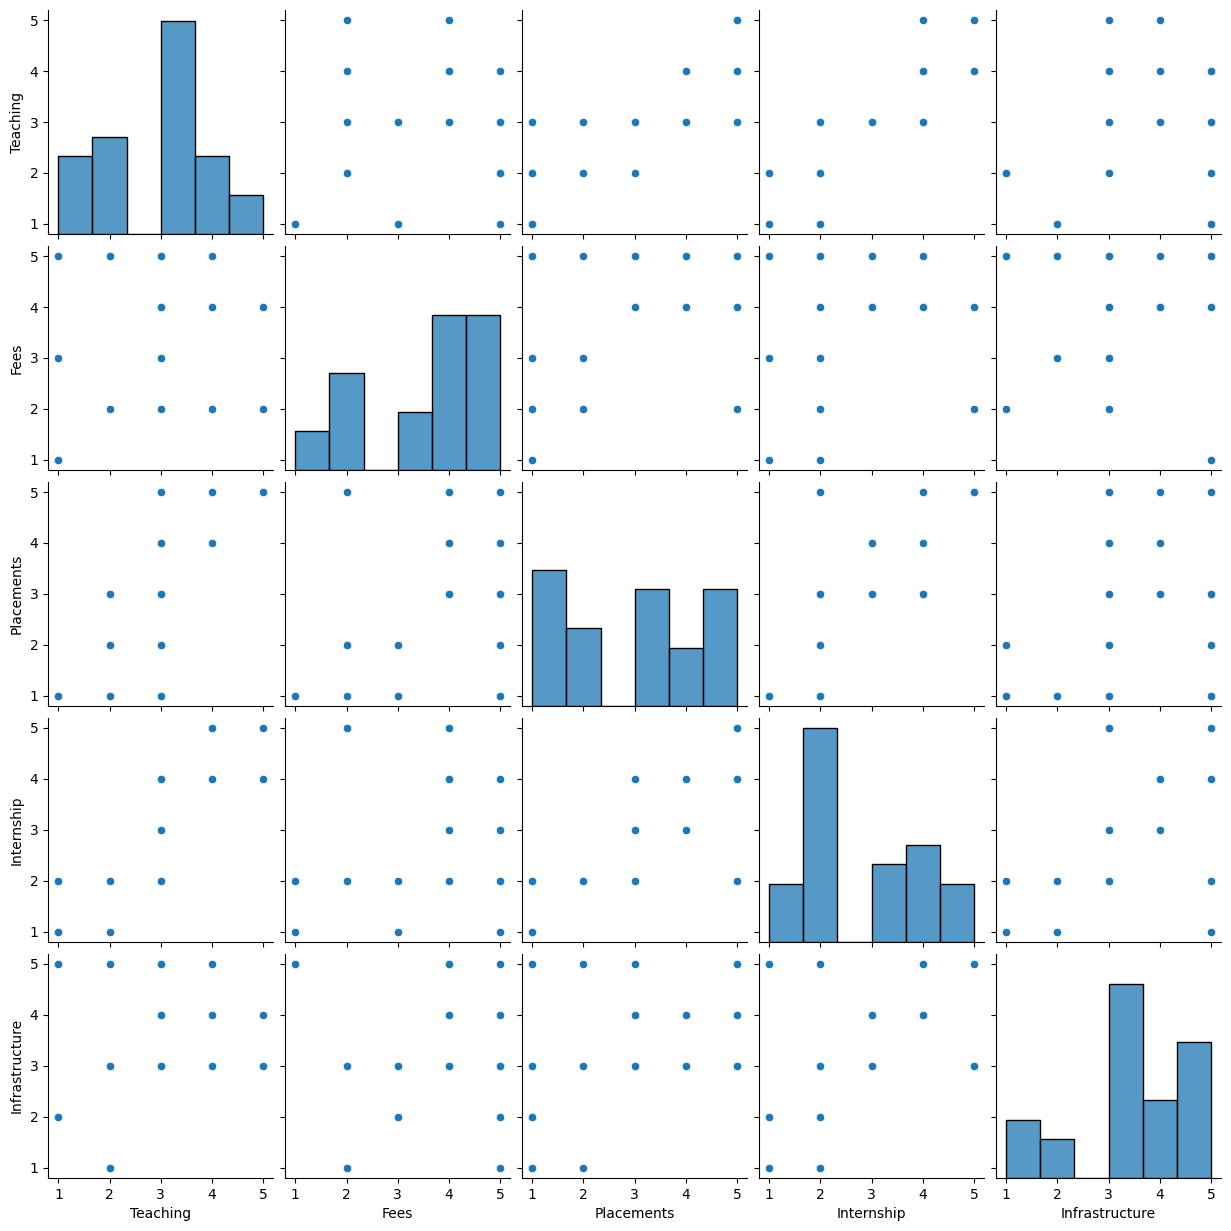

In [10]:
sns.pairplot(train_set[features])

### Ejercicio 5

Podríamos intentar cualquier tipo de clusterización, pero vamos a emplear una clusterización jerárquica porque sea cual sea la agrupación sí que nos interesa establecer una jerarquía o una relación de distancia entre las diferentes instituciones (es algo que nos dicen desde el cliente, o sea "Negocio")

Elegido el tipo de clustering, tenemos que determinar los hiperparámetros. En este caso, el número de clusteres. Para ello nos vamos a apoyar en el dendrograma. Construye el dendrograma utilizando "average" como el método de ligado o linkage.



NOTA: no lo hemos hecho, ni dicho, pero nos quedaremos con todas las variables para sean features y como están en la misma escala no hay que procesarlas otra vez.

In [13]:
link_method = shc.linkage(train_set[features], method='average', metric='euclidean')

In [14]:
labelList = np.array(train_set["Engg_College"])
labelList

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

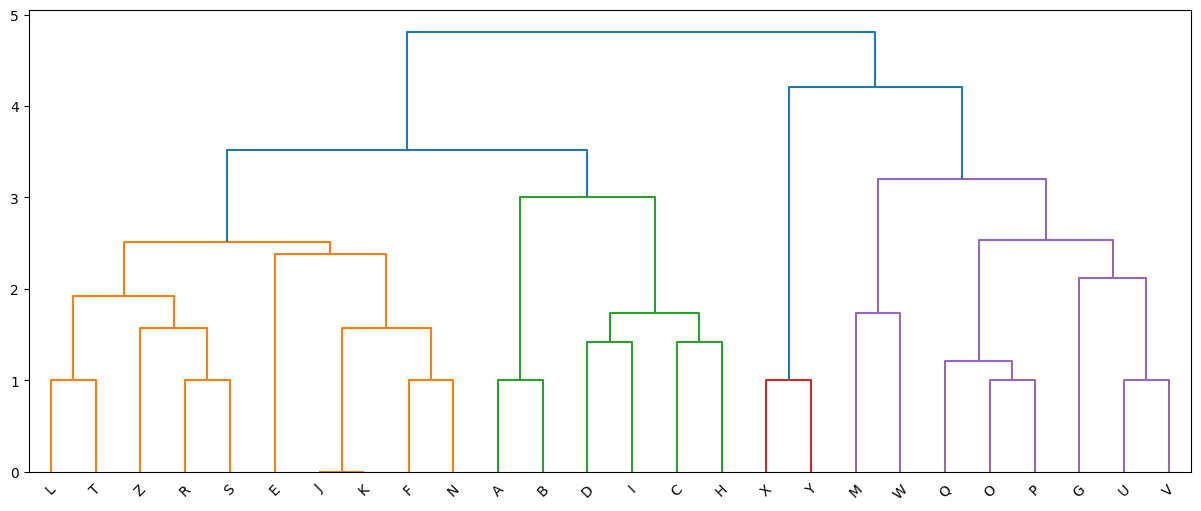

In [15]:
plt.figure(figsize =(15,6))
dend = shc.dendrogram(Z=link_method, labels=labelList)


### Ejercicio 6

Utilizando el método del máximo salto horizontal o método del máximo gap, ¿dónde colocarías la recta de corte? Vuelve a dibujar el dendrograma superponiendo esa línea. Decide el número de clusteres.

*El método sugerido busca la recta que logra obtener la mayor distancia entre dos líneas verticales sin simplificar el clustering a 2. No hace falta que te dejes los ojos, `la función dendrograma que usamos ya utiliza una codificación de colores que te permite saber el número de clusteres sugeridos por este método.` Observa que hay cuatro colores y que corresponden a cortar por las líneas verticales azules (por lo menos en esta solución, puede que el juego de colores en tu ordenador se vea diferente)*

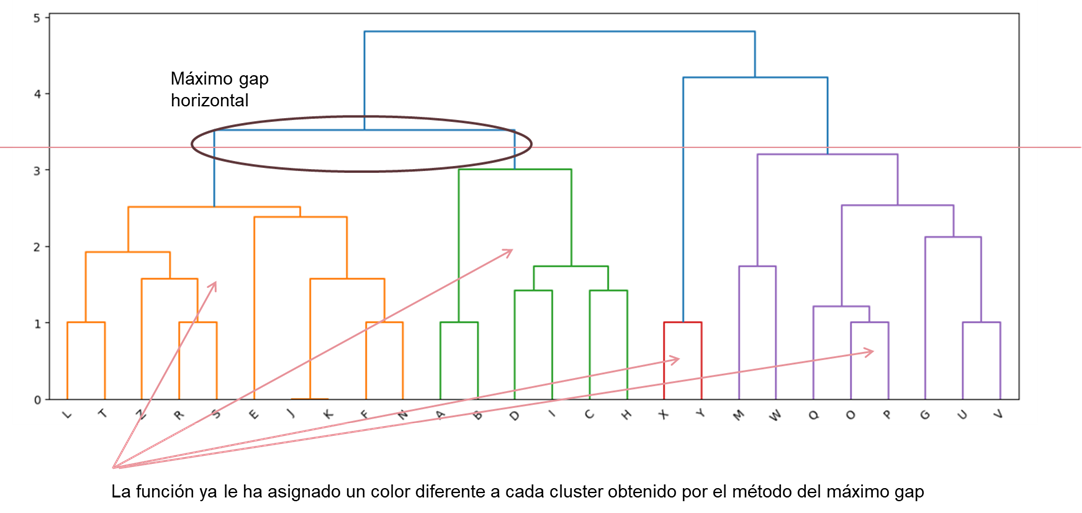

*Solo tenemos que superponer esa línea o una aproximada, que está más o menos en 3.3*

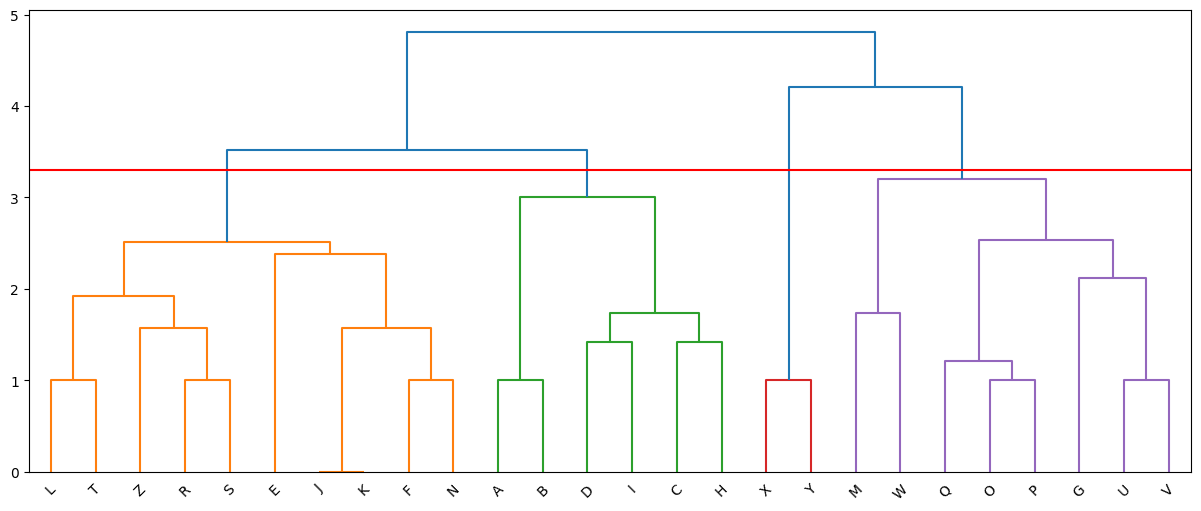

In [15]:
plt.figure(figsize =(15,6))
dend = dendrogram(link_method, labels= labelList)
plt.axhline(y = 3.3, color = 'r', linestyle = '-')

*Según esto, escogemos 4 como el número de clústeres.*

### Ejercicio 7

Utilizando el codigo siguiente, emplea el número de clústeres obtenidos en el ejercicio anterior (usa 4 si no has logrado obtener un número que te convenza) y muestra cuántas instituciones hay por cluster. ¿Qué te llama la atención?

### Crea el cluster jerárquico

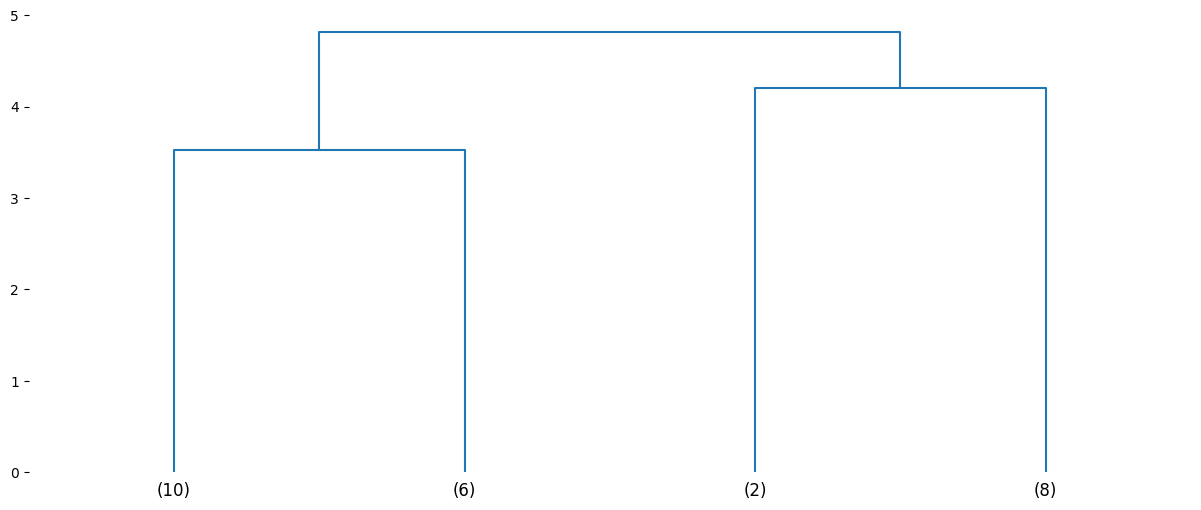

In [16]:
numero_clusters = 4

# Miramos cuantos elementos hay en cada cluster
plt.figure(figsize =(15,6))
dend = shc.dendrogram(Z=link_method,
                 truncate_mode='lastp',
                 p=numero_clusters,
                 labels=labelList 
                 )
sns.despine(left=True, bottom=True)

*El número de elementos del tercer clúster (2) es bastante menor que en el resto, pero viendo el dendrograma (de los ejercicios anteriores) observa que está bastante distanciado del resto (su línea vértical hasta unirse para formar otro clúster es muy alta, desde el clúster en rojo hasta el siguiente). Son dos instituciones que forman un clúster bastante cohesionado (se unen relativamente pronto) y distante del resto* 

### Ejercicio 8

Previo a analizar las características específicas de cada clúster, analiza el clúster con menor número de elementos, es decir muestra las características de sus elementos constituyentes

*Fíjate que son las instituiciones "X" e "Y", veamos sus valores (Si vas al dendrograma del ejercicio 6, y ves las etiquetas del cluster "rojo" el que tiene dos elementos verás que son "X" e "Y"*

In [19]:
train_set[train_set["Engg_College"].isin(["X","Y"])]

,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure
23,X,1,1,1,2,5
24,Y,1,1,1,1,5


*Diríamos que son las "malas" por las puntuaciones tan bajas en todo menos en infraestructuras*

### Ejercicio 9

Nos hemos adelantado en el ejercicio anterior. Es hora de construir el clustering tal como hemos visto en el workout, utiliza el "AgglomerativeClustering" de sklearn para hacer el agrupamiento con el número de clusteres elegido y asigna las etiquetas a cada instancia. (Recuerda que hemos usado el linkage a "average", no a "ward" como se suele emplear)

In [17]:
clustering_model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='average')
clustering_model.fit(train_set[features])
train_set['Cluster'] = clustering_model.labels_

### Ejercicio 10

Comprueba que las instancias asignadas al clúster con 2 instancias son las entidades "X" e "Y"

In [19]:
# Frecuencia de elementos en cada cluster
train_set.Cluster.value_counts()

Cluster
3    10
0     8
1     6
2     2
Name: count, dtype: int64

*Es el cluster 2 el que es pequeño, así que usaremos este valor como filtro*

In [20]:
train_set[train_set.Cluster == 2]

,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure,Cluster
23,X,1,1,1,2,5,2
24,Y,1,1,1,1,5,2


*Todo OK*

### Ejercicio 11

Igual que podemos intuir que el cluster "pequeño" es el de las instituiciones peor puntuadas, muestra los valores medios de las features para cada clúster y da tu interpretación de que es cada uno. Emplea un gráfico comparativo.


In [21]:
features_mean_by_cluster = train_set[features + ["Cluster"]].groupby('Cluster').mean()
features_mean_by_cluster['Freq'] = train_set['Cluster'].value_counts().sort_index()

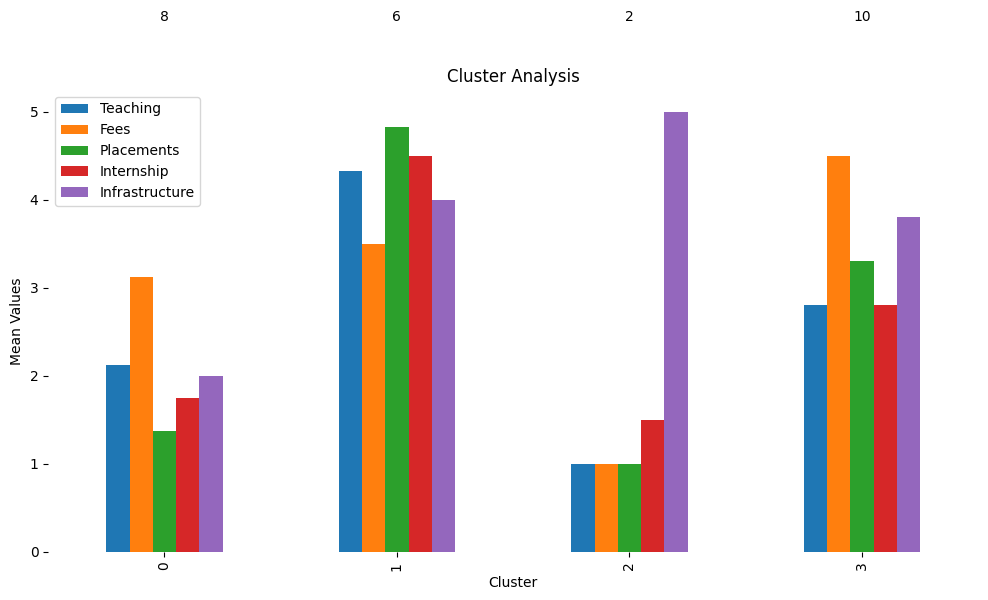

In [22]:
# Perfil de cada cluster
fig, ax = plt.subplots(figsize=(12, 6))
features_mean_by_cluster.iloc[:, :-1].plot(kind='bar', ax=ax)
ax.set_ylabel('Mean Values')
ax.set_title('Cluster Analysis')
for i, v in enumerate(features_mean_by_cluster['Freq']):
    ax.text(i, max(features_mean_by_cluster.iloc[:, :-1].max().max(), 5) + 1, str(v), ha='center', va='bottom')
sns.despine(left=True, bottom=True)
plt.show()

*Podríamos hacer la siguiente interpretación:*
*Cluster 0, escuelas de valoración baja en general y con un coste medio-alto*
*Cluster 1, instituciones top en casi todos los niveles, con un coste medio-alto*
*Cluster 2, instituciones de nivel muy bajo de coste también muy bajo que intentan suplir algo con las instalaciones e infraestructuras*
*Cluster 3, instintuciones de gama media pero con costes altos para sus puntuaciones*

### Ejercicio 12

Para finalizar, ¿qué recomendaciones darías a diferentes clientes en base a los patrones encontrados?

***Recomendaciones***

*1. En general vistos los fees, recomendaría claramente el conjunto de instituciones en el clúster 1 para clientes con un poder adquisitivo mayor.*  

*2. Con un poder adquisitivo medio serían las del cluster 0.*

*3. Con un poder adqusitivo bajo sólo quedan las institucioines del cluster 2, pero a cambio tienen unas buenas instalaciones.*

*4. Seguramente no recomendaríamos el cluster 3, cuya calidad-precio claramente invita irse al cluster 1.*

*Solo hemos empleado el criterio nivel y coste, puede ser que por cercanía o lejanía fuera necesario cambiar estas recomendaciones.*